# Example 2: BigTransfer Image Classification

GSB 545: Final Project

Stephanie Liu

June 7, 2022




# Example Information: 

## Image Classification using BigTransfer (BiT)

**See below for more information on the *original example* this was based on.**

The code example is taken from here: https://keras.io/examples/vision/bit/

**Author:** [Sayan Nath](https://twitter.com/sayannath2350)<br>
**Date created:** 2021/09/24<br>
**Last modified:** 2021/09/24<br>
**Description:** BigTransfer (BiT) State-of-the-art transfer learning for image classification.

Resources Referenced in this Example:

- Neural Networks: https://sanchit2843.medium.com/introduction-to-neural-networks-660f6909fba9

- BigTransfer: https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html

- Example: https://keras.io/examples/vision/bit/


## Introduction



### **Overview of Neural Networks**

A neural network is the basic building block of deep learning, based on aspects of the human brain. It consists of layers stacked together to form a larger architecture. It consists of 3 types of layers, and within each layer, there are neurons, or nodes, that each have their own weight. 

- *Input layer*: This takes the independent variables from the data as input (each node is one variable)
- *Hidden layer(s*): This is the middle section of the model. There can be multiple hidden layers, and within each layer you can specify the number of nodes in each.
- *Output layer*: This is the layer that produces the predicted target variable. In our example, it would produce the predicted class (digit between 0-9) that the observation is assigned to.

Neural Networks are the weighted sum of inputs, that is the sum of each weighted node throughout the model. Keep in mind that in general, Simple Neural Networks take a series of inputs for one observation within the data, pass them through the nodes of each layer of the model, and produce a predicted output for that observation. The model then continues to do this for every observation of the data.


### **Overview  of Convolutional Neural Networks**

Convolutional Neural Networks (CNN) is a class of artificial neural network (ANN), that is commonly applied to analyze visual imagery. It is a Deep Learning algorithm which can take in an input image, assign importance (i.e. updatable weights) to various objects in the image and be able to differentiate one from the other. 


An image is a matrix of pixel values. For instance, an image could be saved as a 3x3 matrix of pixels, and this is how it is stored in the data. The CNN model is able to capture the *Spatial* and *Temporal* dependencies in an image. The network can be trained to better understand the sophistication of the image by applying the relevant filters. The role of the CNN is to reduce the images into an easy-to-process form, without losing features which are essential to getting a good prediction.



### **BigTransfer Image Classification**

**Overview of Transfer Learning:**

While CNN (Convolutional Neural Network) models are typically used for image classification for large datasets, the BigTransfer method allows us to classify images, when there is only a small amount of data. This also allows others to take pre-existing pre-trained models, and adapt it to their own task, without having to build a model from scratch. The way ***transfer learning*** works is that you take a large dataset, and train the CNN model on it (**pre-training**). Then you can "transfer" the CNN model as a starting point for your new model, and use it to train the new model on the smaller dataset (called **fine-tuning**). The idea is that the large dataset and small dataset are somewhat similar, so that the adaptation of the old model to the new one is consistent. 

**BigTransfer (BiT):**

**BigTransfer** is a transfer learning method for image
classification. Transfer of pre-trained representations improves sample efficiency and
simplifies hyperparameter tuning when training deep neural networks for computer vision.

BiT revisit the paradigm of pre-training on large supervised datasets and fine-tuning the
model on a target task. There is an increased importance of appropriately choosing normalization layers and
scaling the architecture capacity as the amount of pre-training data increases. 


BigTransfer(BiT) is trained on public datasets, along with code in [TF2, Jax and Pytorch](https://github.com/google-research/big_transfer). This will help anyone to reach
state of the art performance on their task of interest, even with just a handful of
labeled images per class.

You can find BiT models pre-trained on
[ImageNet](https://image-net.org/challenges/LSVRC/2012/index) and ImageNet-21k in
[TFHub](https://tfhub.dev/google/collections/bit/1) as TensorFlow2 SavedModels that you
can use easily as Keras Layers. There are a variety of sizes ranging from a standard
ResNet50 to a ResNet152x4 (152 layers deep, 4x wider than a typical ResNet50) for users
with larger computational and memory budgets but higher accuracy requirements.

![](https://i.imgur.com/XeWVfe7.jpeg)
Figure: The x-axis shows the number of images used per class, ranging from 1 to the full
dataset. On the plots on the left, the curve in blue above is our BiT-L model, whereas
the curve below is a ResNet-50 pre-trained on ImageNet (ILSVRC-2012).

## Setup

First, we will import all the relevant packages needed for this example.

The model in this example is built using the keras package, which is a part of tensorflow (similar to tidymodels in RStudio). 

The numpy and pandas packages are used for many of the  computational and data-related functions. The matplotlib package is used for plotting.

Since there is randomization throughout the code, we will set the seed (to 42) in order to produce consistent results.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

## Gather Flower Dataset

We will load in the tf_flowers dataset hosted on GCS. When we load it in, we will auto split the data into train and validation sets (using a 85-15 train-validation split). Recall that the model(s) we will use later on will be trained/fitted on the train dataset, and then the validation set will be used for validation, to help us compare the performance of all models tested. Our goal is to corresctly classify the labels to the flower images.

In [24]:
train_ds, validation_ds = tfds.load(
    "tf_flowers", split=["train[:85%]", "train[85%:]"], as_supervised=True,
)

In [25]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

We can see what the train dataset is saved as in the output above. This is not super clear, but we can see that elements of the dataset listed, including the shape, data type, and name. 
We will visualize the dataset below, in order to better understand it.

## Visualise the dataset

Below, we will use a for loop to plot the images in the dataset. This will give us a better idea of what the data looks like. Below, we see that the data can be plotted as an image, and has a corresponding label attached to it (written above the image, and should range from 0-4, since there are 5 classes).

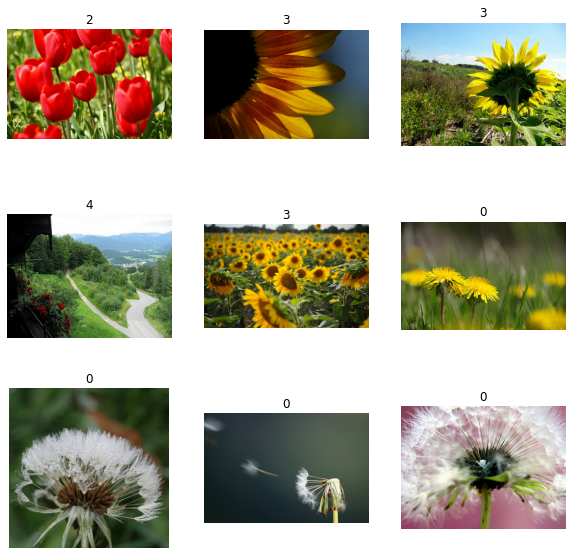

In [26]:
plt.figure(figsize=(10, 10)) # set overall figure to 10x10 size
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image) 
    plt.title(int(label))
    plt.axis("off")

# for each index in the data, and corresponding image and label, plot the image, and use the label as a title.    

## Define hyperparameters

Within the model, there are multiple parameters (referred to as hyperparameters). We can set these parameters before running the model, as we do in the code chunk below. 

The hyperparameters like `SCHEDULE_LENGTH` and `SCHEDULE_BOUNDARIES` are determined based
on empirical results. The method has been explained in the [original
paper](https://arxiv.org/abs/1912.11370) and in their [Google AI Blog
Post](https://ai.googleblog.com/2020/05/open-sourcing-bit-exploring-large-scale.html).

The `SCHEDULE_LENGTH` is also determined whether to use [MixUp
Augmentation](https://arxiv.org/abs/1710.09412) or not. You can also find an easy MixUp
Implementation in [Keras Coding Examples](https://keras.io/examples/vision/mixup/).

![](https://i.imgur.com/oSaIBYZ.jpeg)

In [27]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

## Define preprocessing helper functions

The functions created below will help us in preprocessing the training and test data before implementing the model. This will help get the data ready for the model we pass it through.

These preprocessing functions include:
- image flipping (random)
- image resizing
- image cropping (random)
- image normalization (where we "scale" the image by dividing by 255, the number of pixels)

In [28]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE 
# schedule length = 500 * 512 / 64


@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

## Define the data pipeline

After preprocessing the data, we create the data pipeine for the train and test sets. This pipeline acts as a workflow for the process that the data should go through before being passed into the model. Here is where we call the two preprocessing functions created in the code chunk above.

In [29]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Visualise the training samples

Now that we have finished preprocessing the data, we will visualize the training data that we intend to pass into the model. This process is similar to how we previously visualized the data, but you'll notice that the output is slightly different, after completing the steps above on the original training dataset. We can see that the labels are ranging from integers 0-4, which indicates there are 5 classes, as specified previously.

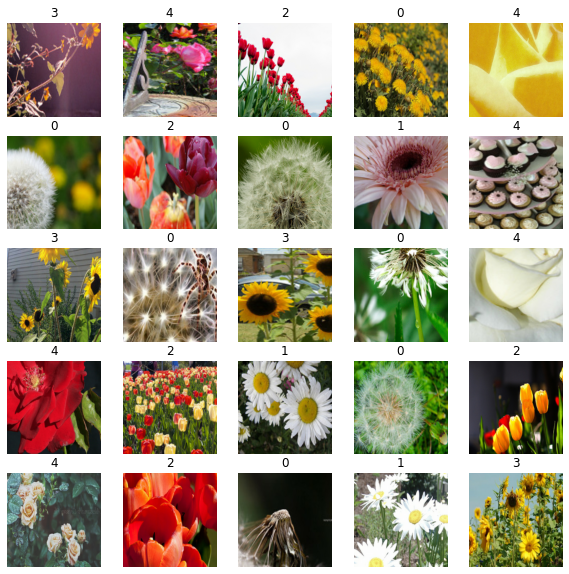

In [30]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10)) # set figure to 10x10 size
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

# for each n in vector (0:25), plot 5x5 subplots, plot the image batch, and its corresponding label

## Load pretrained TF-Hub model into a `KerasLayer`

As discussed in the overview of BigTransfer learning in the beginning of this example, we want to take a pre-trained model that already exists, and modify it (fine-tune it) to fit our task. The model we load in below is the pre-trained model that we will build off of.

In [31]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

## Create BigTransfer (BiT) model

To create the new model, we:

1. Cut off the BiT model’s original head (i.e. beginning layer(s) of the model). This leaves us with the “pre-logits” output.
We do not have to do this if we use the ‘feature extractor’ models (i.e. all those in
subdirectories titled `feature_vectors`), since the head has already
been cut off for those models.

2. Add a new head with the number of outputs equal to the number of classes of our new
task. Note that it is important that we initialise the head to all zeroes.

The functions below will execute these two steps. Take note that the new head added uses the keras Dense layer, which takes as input the number of classes to output (which we specified to be 5 when defining the hyperparameters). 

In [32]:

class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

## Define optimizer and loss

Many models created through the keras package will need a specification of the optimizer and loss functions to use for computation in our model. 
We will do this below.

We specify:
- **SGD Optimizer** : Gradient descent (with momentum) optimizer.
    - *learning rate* that decays by a factor of 10
    - *momentum* = 0.9 (accelerates gradient descent in the relevant direction and dampens oscillations)

- **Sparse Categorical Crossentropy loss function** : Computes the crossentropy loss between the labels and predictions. Use this crossentropy loss function when there are two or more label classes (we have 5 in our example). We expect labels to be provided as integers.      

In [33]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Compile the model

The next step in fine-tuning the model is to implement the **compile** function, which allows us to specify the *optimizer*, *loss function* and preferred *metrics*.

We have already specified the optimizer and loss function in the code chunk above. We will also specify the metric to measure accuracy, which is a common metric to use for classification (calculates how often predictions equal labels).

In [34]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

## Set up callbacks

A callback is an object that can perform actions at various stages of training.

You can use callbacks to:

- Write TensorBoard logs after every batch of training to monitor your metrics
- Periodically save your model to disk
- Do early stopping
- Get a view on internal states and statistics of a model during training

Here, we are using the callbacks to do early stopping, which stops training when a monitored metric has stopped improving. 

- *monitor* = "val_accuracy" : early stopping when the accuracy has stopped improving
- *patience* = 2 : Number of epochs with no improvement after which training will be stopped.
- *restore_best_weight*s = True : Whether to restore model weights from the epoch with the best value of the monitored quantity.

You will notice later on when we train the model, that there are hundreds of epochs specified. Applying the early stopping callback will allow us to stop the model before running all epochs, if it is not neccessary to do so. 

In [35]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

## Train the model

Finally, we are ready to train the model on the data! Note that we specify the following when fitting:

- *train data*

- *batch size* : Number of samples per gradient update.

- *epochs* : Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. 

- *steps_per_epoch* : Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.

- *validation_data* : Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.

- *callbacks* : List of callbacks to apply during training.

In [36]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400
10/10 [==============================] - 538s 56s/step - loss: 0.7379 - accuracy: 0.7875 - val_loss: 0.1860 - val_accuracy: 0.9582
Epoch 2/400
10/10 [==============================] - 517s 56s/step - loss: 0.1367 - accuracy: 0.9594 - val_loss: 0.1130 - val_accuracy: 0.9691
Epoch 3/400
10/10 [==============================] - 516s 56s/step - loss: 0.1766 - accuracy: 0.9453 - val_loss: 0.0858 - val_accuracy: 0.9709
Epoch 4/400
10/10 [==============================] - 515s 56s/step - loss: 0.1166 - accuracy: 0.9594 - val_loss: 0.0861 - val_accuracy: 0.9709
Epoch 5/400
10/10 [==============================] - 514s 56s/step - loss: 0.1388 - accuracy: 0.9453 - val_loss: 0.0784 - val_accuracy: 0.9709


## Plot the training and validation metrics

Now that we've fit the model on the training data, we can see how the model performs on the train set. The code below will show a visual of these metrics, using various plotting functions from the matplotlib package.

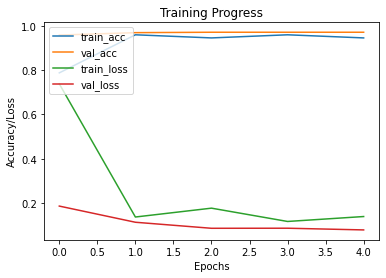

In [37]:

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

Here we can see that train accuracy (blue), validation/test accuracy (orange), train loss (green), validation/test loss (red). The accuracy for both the train and validation sets seem to increase at the first few epochs, and then steady, while their loss functions decrease and then steady a bit. We see that the train and validation accuracy lines follow fairly closely together. 

## Evaluate the model

Next, we want to determine how well the model performs. We have fit the model on the train dataset, and now we can evaluate the model on the test (validation) dataset. The code below will print the test accuracy of the model, which compares the true outputs from the test data to how the model predicts/classifies the images.

In [38]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 365s 40s/step - loss: 0.0858 - accuracy: 0.9709
Accuracy: 97.09%


We see that the model classifies the images with over **97% accuracy**, which is pretty good! Therfore, this model seems to work well for the task that we've implemented it to do.

## Conclusion

BiT performs well across a surprisingly wide range of data regimes
-- from 1 example per class to 1M total examples. BiT achieves 87.5% top-1 accuracy on
ILSVRC-2012, 99.4% on CIFAR-10, and 76.3% on the 19 task Visual Task Adaptation Benchmark
(VTAB). On small datasets, BiT attains 76.8% on ILSVRC-2012 with 10 examples per class,
and **97.0%** on CIFAR-10 with 10 examples per class.

![](https://i.imgur.com/b1Lw5fz.png)

You can experiment further with the BigTransfer Method by following the [original paper](https://arxiv.org/abs/1912.11370).